Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Define paths
train_dir = "./extracted_fruits/FRUIT-16K/train"
test_dir = "./extracted_fruits/FRUIT-16K/test"

In [3]:
# Image parameters
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation/test
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
# Check if directories exist
if not os.path.exists(train_dir):
    raise FileNotFoundError(f"Training directory not found: {train_dir}")
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Testing directory not found: {test_dir}")

# Print available class directories
print("Available training classes:")
for cls in sorted(os.listdir(train_dir)):
    num_images = len(os.listdir(os.path.join(train_dir, cls)))
    print(f"  - {cls}: {num_images} images")

print("\nAvailable testing classes:")
for cls in sorted(os.listdir(test_dir)):
    num_images = len(os.listdir(os.path.join(test_dir, cls)))
    print(f"  - {cls}: {num_images} images")

Available training classes:
  - banana_fresh: 800 images
  - banana_spoiled: 800 images
  - lemon_fresh: 800 images
  - lemon_spoiled: 800 images
  - lulo_fresh: 800 images
  - lulo_spoiled: 800 images
  - mango_fresh: 800 images
  - mango_spoiled: 800 images
  - orange_fresh: 800 images
  - orange_spoiled: 800 images
  - strawberry_fresh: 800 images
  - strawberry_spoiled: 800 images
  - tamarillo_fresh: 800 images
  - tamarillo_spoiled: 800 images
  - tomato_fresh: 800 images
  - tomato_spoiled: 800 images

Available testing classes:
  - banana_fresh: 200 images
  - banana_spoiled: 200 images
  - lemon_fresh: 200 images
  - lemon_spoiled: 200 images
  - lulo_fresh: 200 images
  - lulo_spoiled: 200 images
  - mango_fresh: 200 images
  - mango_spoiled: 200 images
  - orange_fresh: 200 images
  - orange_spoiled: 200 images
  - strawberry_fresh: 200 images
  - strawberry_spoiled: 200 images
  - tamarillo_fresh: 200 images
  - tamarillo_spoiled: 200 images
  - tomato_fresh: 200 images
  -

In [5]:
# Load train and test data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Get class mapping
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"\nClass names: {class_names}")
print(f"Number of classes: {num_classes}")

Found 12800 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.

Class names: ['banana_fresh', 'banana_spoiled', 'lemon_fresh', 'lemon_spoiled', 'lulo_fresh', 'lulo_spoiled', 'mango_fresh', 'mango_spoiled', 'orange_fresh', 'orange_spoiled', 'strawberry_fresh', 'strawberry_spoiled', 'tamarillo_fresh', 'tamarillo_spoiled', 'tomato_fresh', 'tomato_spoiled']
Number of classes: 16


Sample Images


Showing sample training images:


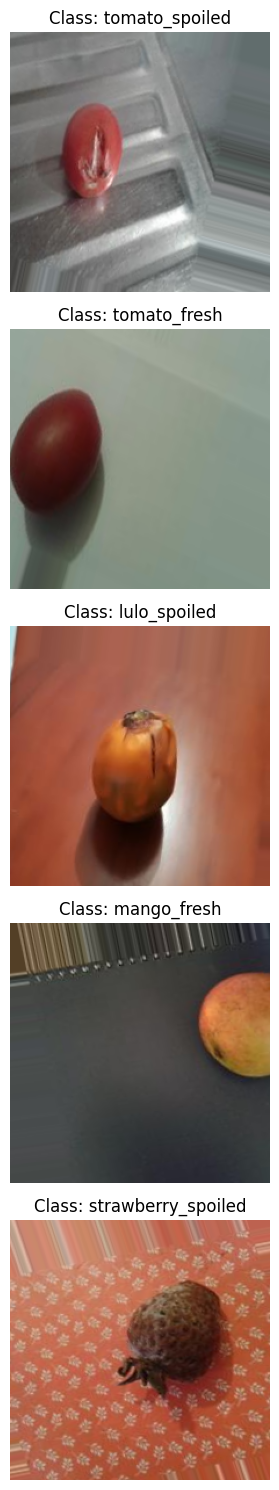

In [28]:
def show_samples(generator, n=5):
    plt.figure(figsize=(15, 3*n))
    for i in range(n):
        # Get a batch of images
        x_batch, y_batch = next(generator)
        # Select a random image
        idx = random.randint(0, len(x_batch) - 1)
        img = x_batch[idx]
        label = np.argmax(y_batch[idx])
        
        plt.subplot(n, 1, i + 1)
        plt.imshow(img)
        plt.title(f"Class: {class_names[label]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\nShowing sample training images:")
show_samples(train_generator)

CNN Model

In [10]:
def build_model():
    # model = models.Sequential([
    #     # First convolutional block
    #     layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    #     layers.BatchNormalization(),
    #     layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D((2, 2)),
    #     layers.Dropout(0.25),
        
    #     # Second convolutional block
    #     layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    #     layers.BatchNormalization(),
    #     layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D((2, 2)),
    #     layers.Dropout(0.25),
        
    #     # Third convolutional block
    #     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    #     layers.BatchNormalization(),
    #     layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    #     layers.BatchNormalization(),
    #     layers.MaxPooling2D((2, 2)),
    #     layers.Dropout(0.25),
        
    #     # Dense layers
    #     layers.Flatten(),
    #     layers.Dense(512, activation='relu'),
    #     layers.BatchNormalization(),
    #     layers.Dropout(0.5),
    #     layers.Dense(num_classes, activation='softmax')
    # ])

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create and train the model
model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         2,064 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,024 (42.61 MB)

 Trainable params: 11,171,024 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Add callbacks for better training but with reduced training time
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=1, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(
        'best_fruit_model.keras', 
        save_best_only=True, 
        monitor='val_accuracy'
    )
]

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 537s 1s/step - accuracy: 0.2554 - loss: 2.3177 - val_accuracy: 0.6587 - val_loss: 1.0500 - learning_rate: 0.0010
Epoch 2/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 473s 1s/step - accuracy: 0.5940 - loss: 1.1650 - val_accuracy: 0.7419 - val_loss: 0.7013 - learning_rate: 0.0010
Epoch 3/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.6874 - loss: 0.8653 - val_accuracy: 0.8103 - val_loss: 0.5404 - learning_rate: 0.0010
Epoch 4/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 438s 1s/step - accuracy: 0.7527 - loss: 0.6878 - val_accuracy: 0.8712 - val_loss: 0.3632 - learning_rate: 0.0010
Epoch 5/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 427s 1s/step - accuracy: 0.8160 - loss: 0.5275 - val_accuracy: 0.8925 - val_loss: 0.3025 - learning_rate: 0.0010
Epoch 6/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.8320 - loss: 0.4642 - val_accuracy: 0.9041 - val_loss: 0.2619 - learning_rate: 0.0010
Epoch 7/10
400/400 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.8524 - loss: 0.

Evaluation of the Model

In [12]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 55s 549ms/step - accuracy: 0.9802 - loss: 0.0666

Test accuracy: 0.9641
Test loss: 0.1168


Plot Training History

Confusion Matrix

100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 244ms/step


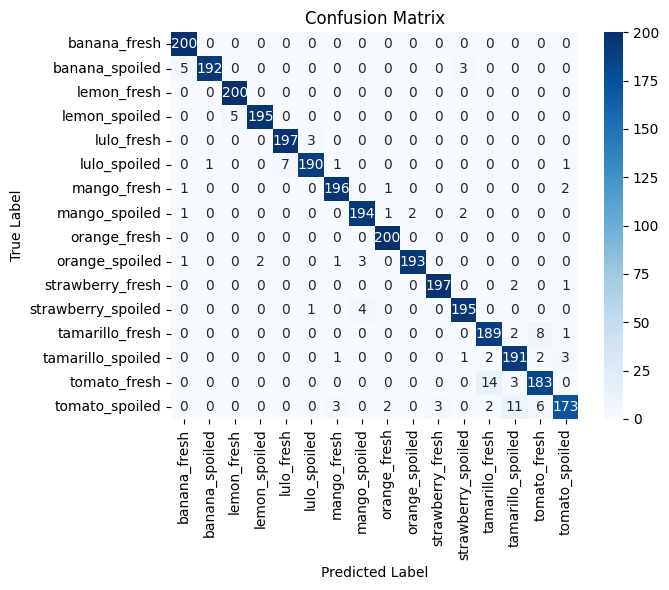


Classification Report:
                    precision    recall  f1-score   support

      banana_fresh       0.96      1.00      0.98       200
    banana_spoiled       0.99      0.96      0.98       200
       lemon_fresh       0.98      1.00      0.99       200
     lemon_spoiled       0.99      0.97      0.98       200
        lulo_fresh       0.97      0.98      0.98       200
      lulo_spoiled       0.98      0.95      0.96       200
       mango_fresh       0.97      0.98      0.98       200
     mango_spoiled       0.97      0.97      0.97       200
      orange_fresh       0.98      1.00      0.99       200
    orange_spoiled       0.99      0.96      0.98       200
  strawberry_fresh       0.98      0.98      0.98       200
strawberry_spoiled       0.97      0.97      0.97       200
   tamarillo_fresh       0.91      0.94      0.93       200
 tamarillo_spoiled       0.91      0.95      0.93       200
      tomato_fresh       0.92      0.92      0.92       200
    tomato_spoi

In [27]:
def plot_confusion_matrix():
    # Get predictions
    Y_pred = model.predict(test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    # Get true labels
    y_true = test_generator.classes
    
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Calculate overall metrics
    total_correct = np.sum(np.diag(cm))
    total_samples = np.sum(cm)
    overall_accuracy = total_correct / total_samples
    
    print(f"\nOverall Test Accuracy: {overall_accuracy:.4f}")
    
    # Calculate metrics per category
    print("\nCategory-wise Performance:")
    for i, class_name in enumerate(class_names):
        class_correct = cm[i, i]
        class_total = np.sum(cm[i, :])
        class_accuracy = class_correct / class_total if class_total > 0 else 0
        print(f"{class_name}: {class_accuracy:.4f} ({class_correct}/{class_total})")

plot_confusion_matrix()

Prediction of Multiple Random Images


Predicting random test images:

Random Test Image #1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


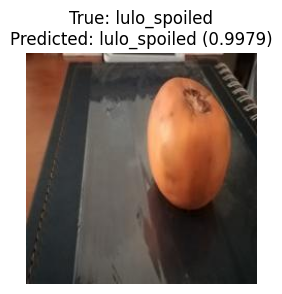

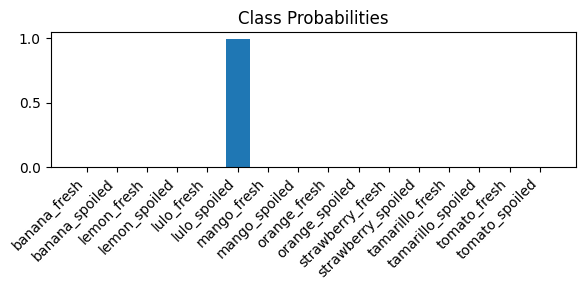

True label: lulo_spoiled
Predicted label: lulo_spoiled
Top 3 predictions:
  lulo_spoiled: 0.9979
  lulo_fresh: 0.0021
  tomato_spoiled: 0.0000

Random Test Image #2:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


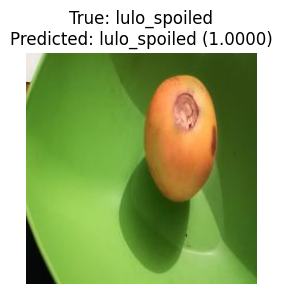

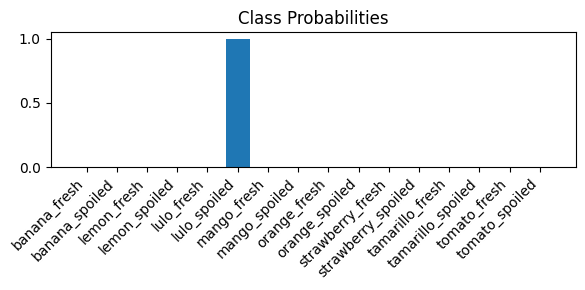

True label: lulo_spoiled
Predicted label: lulo_spoiled
Top 3 predictions:
  lulo_spoiled: 1.0000
  lemon_fresh: 0.0000
  lemon_spoiled: 0.0000

Random Test Image #3:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


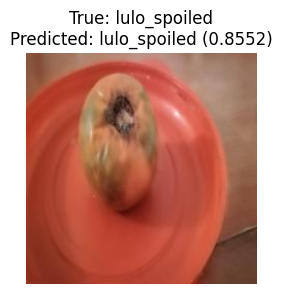

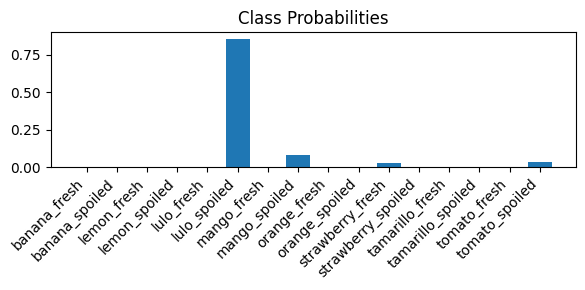

True label: lulo_spoiled
Predicted label: lulo_spoiled
Top 3 predictions:
  lulo_spoiled: 0.8552
  mango_spoiled: 0.0807
  tomato_spoiled: 0.0329

Model saved to 'fruit_freshness_model.h5'


In [26]:
# Function to predict a random image
def predict_random_image():
    # Get a random batch from the test generator
    x_batch, y_batch = next(test_generator)
    
    # Select a random image from the batch
    idx = np.random.randint(0, len(x_batch))
    img = x_batch[idx]
    true_label = np.argmax(y_batch[idx])
    
    # Make prediction
    pred = model.predict(np.expand_dims(img, axis=0))[0]
    pred_label = np.argmax(pred)
    
    # Plot image and prediction
    plt.figure(figsize=(4, 3))
    plt.imshow(img)
    plt.title(f'True: {class_names[true_label]}\nPredicted: {class_names[pred_label]} ({pred[pred_label]:.4f})')
    plt.axis('off')
    plt.show()
    
    # Show all class probabilities
    plt.figure(figsize=(6, 3))
    plt.bar(class_names, pred)
    plt.title('Class Probabilities')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return class_names[true_label], class_names[pred_label], pred

# Predict multiple random images
print("\nPredicting random test images:")
for i in range(3):
    print(f"\nRandom Test Image #{i+1}:")
    true_label, pred_label, pred_probs = predict_random_image()
    print(f"True label: {true_label}")
    print(f"Predicted label: {pred_label}")
    
    # Print top 3 predictions
    top_indices = np.argsort(pred_probs)[::-1][:3]
    print("Top 3 predictions:")
    for idx in top_indices:
        print(f"  {class_names[idx]}: {pred_probs[idx]:.4f}")

# Save the model
model.save('fruit_freshness_model.h5')
print("\nModel saved to 'fruit_freshness_model.h5'")